some links
https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/ - where the datasets are present

https://youtu.be/qYhTdcYhhk8?si=yAsn8iWIjGl7fcG- - vid


## **Import Libs**

In [1]:
# Standard Libraries
import math

# 3rd-Party Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import xgboost

In [2]:
train_fd001 = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt", sep=" ", header=None)
test_fd001 = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt", sep=" ", header=None)

## **Data Prep**

In [3]:
train_fd001.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


clearly row 26 & 27 need to be droped

In [4]:
train_fd001 = train_fd001.drop([26,27], axis="columns")
test_fd001 = test_fd001.drop([26,27], axis="columns")

In [5]:
column_names = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50',
           'P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed',
           'Nf_dmd','PCNfR_dmd','W31','W32']

### Its missing header/attribute row

In [6]:
train_fd001.columns = column_names
test_fd001.columns = column_names

In [7]:
train_fd001.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


### delete columns with constant values ​​that do not carry information about the state of the unit

In [8]:
train_fd001.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [9]:
def prepare_train_data(data, factor=0):
    # Calculate RUL using groupby and transform
    data['RUL'] = data.groupby('unit_number')['time_in_cycles'].transform(max) - data['time_in_cycles']
    
    # Filter rows based on the factor
    result = data[data['time_in_cycles'] > factor].copy()
    #result.drop(columns=['unit_number'], inplace=True)  # Optionally drop the 'unit_number' column
    
    return result

In [10]:
df = prepare_train_data(train_fd001)
df

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


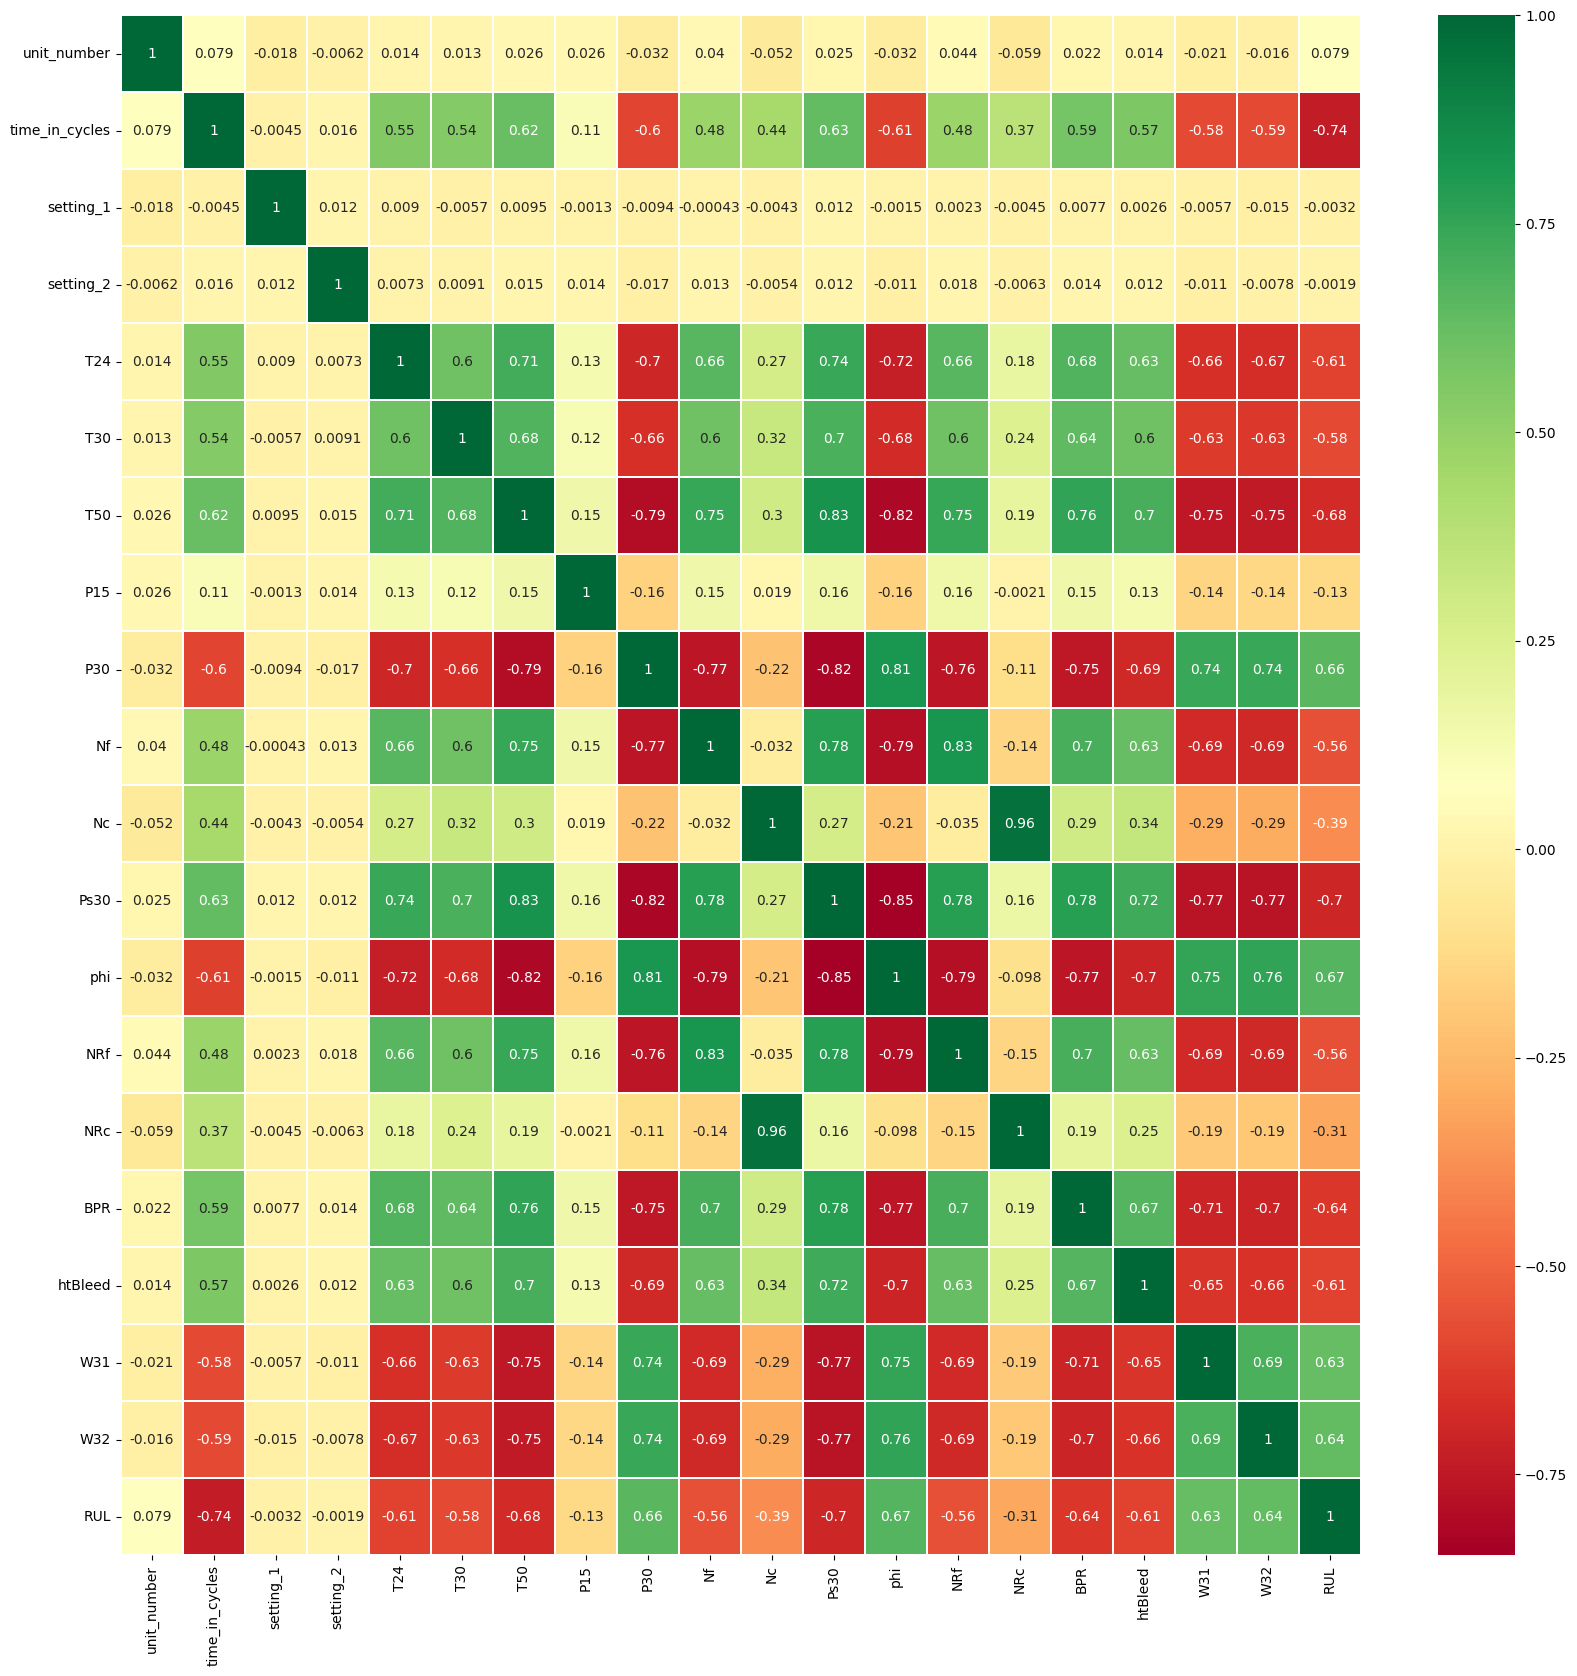

In [11]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

### We eliminate properties weakly correlated with the RUL target, namely setting_1, setting_2, P15, and unit_number. Additionally, to avoid redundancy, one of the highly correlated features, NRc, is removed due to its correlation coefficient of 0.96 with Nc.

In [12]:
unit_number = pd.DataFrame(df["unit_number"]) # we might require it latter
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])
train_df.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


## **Error Function for Competitive Data**

### function calculates a score based on the difference between predicted and true values using a specific formula

In [13]:
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

### Function calculates and prints several metrics related to the performance of a predictive model

In [14]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    print(f' Compatitive Score : {lst[0]}')
    print(f" Mean Absolute Error (MAE) : {lst[1]}")
    print(f" Root Mean Squared Error (RMSE) : {lst[2]}")
    print(f' R2 score : {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]

In [15]:
def train_models(data, model_type='FOREST'):
    """
    Trains a regression model on the given data using Random Forest or XGBoost algorithm.
    
    Parameters:
        data (DataFrame): Input data containing features and target variable.
        model_type (str): Type of model to train ('FOREST' or 'XGB'). Default is 'FOREST'.
        
    Returns:
        Trained regression model.
    """
    X = data.iloc[:, :14].values  # Extracting features (columns 0 to 13) and converting to NumPy array
    Y = data.iloc[:, 14].values  # Extracting target (column 14) and converting to NumPy array
    #Y = np.ravel(Y) #Flattens the target array to a 1-dimensional array if needed
    
    if model_type == 'FOREST':
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
    elif model_type == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                                     colsample_bytree=0.5, max_depth=3, silent=True)
    
    model.fit(X, Y)  # Training the selected model
    return model


In [16]:
def plot_results(y_true, y_pred):
    """
    Plots the real and predicted values for comparison.

    Parameters:
        y_true (array-like): Array of true (actual) values.
        y_pred (array-like): Array of predicted values.

    Returns:
        None
    """
    rcParams['figure.figsize'] = 12, 10
    plt.plot(y_pred, label='Predicted')
    plt.plot(y_true, label='True')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('Training Samples')
    plt.legend(loc='upper right')
    plt.title('Comparison of Real and Predicted Values')
    plt.show()

In [17]:
test_fd001.drop(columns=['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr'], inplace=True)

# Find rows with maximum time_in_cycles for each unit
test = test_fd001.loc[test_fd001.groupby('unit_number')['time_in_cycles'].idxmax()]

# Drop unnecessary columns and convert to NumPy array
X_001_test = test.drop(columns=['unit_number', 'setting_1', 'setting_2', 'P15', 'NRc']).to_numpy()

# Check the shape of the resulting NumPy array
X_001_test.shape


(100, 14)

In [18]:
model_1 = train_models(train_df)

In [19]:
y_pred = model_1.predict(X_001_test)

In [20]:
RUL = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt",sep=" ",header=None)

In [21]:
y_true = RUL[0].to_numpy()

In [22]:
score_func(y_true, y_pred)

 Compatitive Score : 1057.2
 Mean Absolute Error (MAE) : 19.25
 Root Mean Squared Error (RMSE) : 24.45219826518671
 R2 score : 0.65


[19.25, 24.45, 65.0]

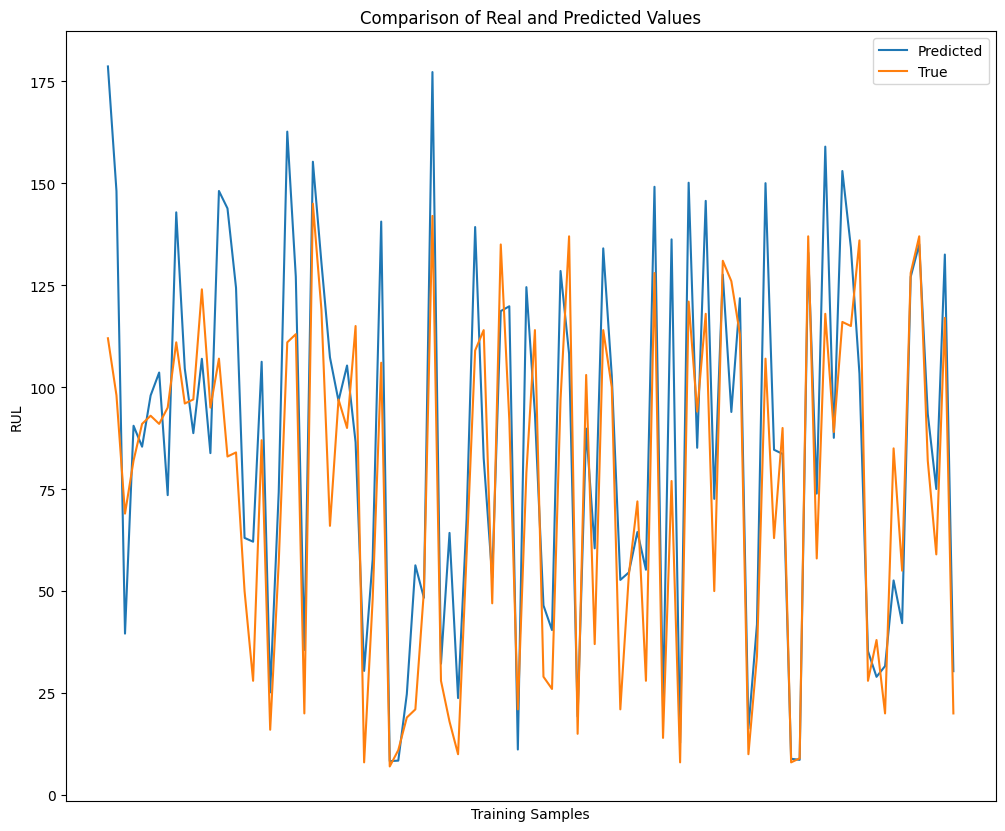

In [23]:
plot_results(y_true,y_pred)